# PPI power analysis

This notebook demonstrates the PPI power analysis from [3, Section 3]. The power analysis returns two samples sizes: `n` - the size of the labeled dataset and `N` - the size of unlabeled dataset. The power analysis is for PPI++ with power tuning [2, Section 6].

Two types of power analysis are implemented, the most powerful pair and the cheapest pair. The **most powerful pair** returns the pair `(n, N)` that maximizes the effective sample size of the PPI estimator subject to a constraint on the cost. The **cheapest pair** returns the pair `(n, N)` that minimizes the cost subject to a constraint on the effective sample size.

The power analysis also returns two measurements of the effectiveness of PPI. These are the PPI correlation and the effective sample size. The **PPI correlation** measures the similarity between the estimate derived from the labeled data and the estimate based on the predictions. The **effective sample size** is the number of labels that would be needed for classical inference to achieve the same level of power as PPI with `n` labels and `N` predictions.

The full output from any of the power analysis functions is a dictionary containing:
* `n` -- the size of the labeled dataset
* `N` -- the size of the unlabeled dataset
* `cost` -- the total cost of gathering the two datasets and performing PPI
* `effective_n` -- the effective sample size
* `ppi_corr` -- the PPI correlation

The power analysis is **data-driven**. To perform the power analysis, the user must supply a dataset with labels $Y_i$, predictions $f(X_i)$ and covariates $X_i$. The dataset could be from a pilot experiment. The power analysis then returns the optimal pair `(n, N)` for a new experiment.

The power analysis is implemented for inference on the mean, linear regression coefficients, and generalized linear model coefficients. Functions are named `ppi_[estimand]_power`. There is also a generic function `ppi_power` that allows the user to specify the PPI correlation.
    
References 
* [1] Angelopoulos, A. N., Bates, S., Fannjiang, C., Jordan, M. I., & Zrnic, T. (2023). Prediction-powered inference. Science, 382(6671), 669-674.  https://www.science.org/doi/full/10.1126/science.adi6000 
* [2] Angelopoulos, A. N., Duchi, J. C., & Zrnic, T. (2023). PPI++: Efficient prediction-powered inference. https://arxiv.org/abs/2311.01453
* [3] Broska, D., Howes, M., & van Loon, A. (2024). The Mixed Subjects Design: Treating Large Language Models as  (Potentially) Informative Observations. https://doi.org/10.31235/osf.io/j3bnt



In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import matplotlib.pyplot as plt
from ppi_py.datasets import load_dataset
from ppi_py.ppi_power_analysis import (
    ppi_power,
    ppi_mean_power,
    ppi_ols_power,
    ppi_logistic_power,
    ppi_poisson_power,
)
from utils import *
import warnings

warnings.simplefilter("always", UserWarning)
np.random.seed(0)  # For reproducibility

## Power analysis for the mean

The function `ppi_mean_power` performs a power analysis for estimating the mean of $Y$. The functionality is similar to all `ppi_[estimand]_power` functions.



The inputs for `ppi_mean_power` are
* `Y` -- the labels $\{Y_i\}_{i=1}^n$
* `Yhat` -- the predictions on the labeled data $\{f(X_i)\}_{i=1}^n$
* `cost_Y` -- the cost of a label $Y_i$
* `cost_Yhat` -- the cost of a prediction $f(X_i)$
* Either `budget` (for the most powerful pair) or `effective_n` (for the cheapest pair)


### The most powerful pair

The most powerful pair is computed by giving `budget` as an input to `ppi_power_mean`. The below code computes the most powerful pair assuming `cost_Y = 1`, `cost_Yhat = 0.1` and `budget = 1000`. These costs mean that predictions are ten times cheaper than labels and that the budget can buy 1,000 labels. In this example, using PPI with the optimal sample sizes is equivalent to having `effective_n = 3557` labels.

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "ballots")
Y = data["Y"]
Yhat = data["Yhat"]

n = Y.shape[0]
n_initial = 500
initial_data = np.random.choice(n, n_initial, replace=False)

Y_initial = Y[initial_data]
Yhat_initial = Yhat[initial_data]

budget = 1000
cost_Y = 1
cost_Yhat = 0.1

powerful_pair = ppi_mean_power(
    Y_initial,
    Yhat_initial,
    cost_Y,
    cost_Yhat,
    budget=budget,
)

powerful_pair

{'n': 418,
 'N': 5398,
 'cost': 999.6,
 'effective_n': 3557,
 'ppi_corr': 0.975093210410465}

The below plot shows optimality of the most powerful pair. The pair of sample sizes `(n, N)` achieves the budget and gives the smallest possible standard error within the budget.

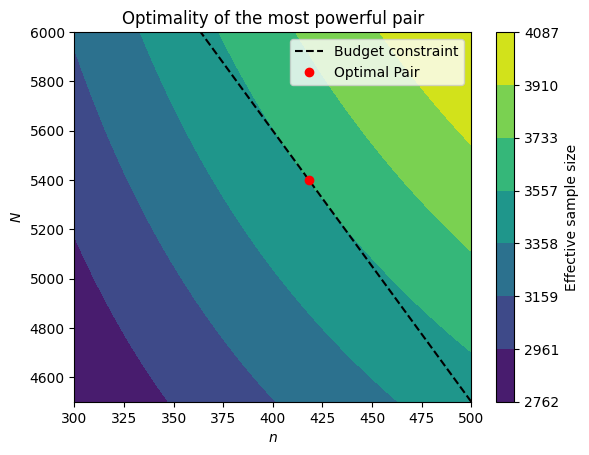

In [3]:
n_opt = powerful_pair["n"]
N_opt = powerful_pair["N"]
rho = powerful_pair["ppi_corr"]

n = np.linspace(300, 500, 100)
N = np.linspace(4500, 6000, 100)

ns, Ns = np.meshgrid(n, N)


def ppi_effective_n(n, N, rho):
    return n * (n + N) / (n + N * (1 - rho**2))


effective_ns = ppi_effective_n(ns, Ns, rho)
m = np.min(effective_ns)
M = np.max(effective_ns)
effective_n_opt = ppi_effective_n(n_opt, N_opt, rho)
levels = np.concat(
    [
        np.linspace(m, effective_n_opt, 5),
        np.linspace(effective_n_opt, M, 4)[1:],
    ]
)

plt.contourf(ns, Ns, effective_ns, levels=levels)

n_cost = (budget - (cost_Yhat * N)) / (cost_Yhat + cost_Y)
plt.plot(n_cost, N, "k--", label="Budget constraint")

plt.plot(n_opt, N_opt, "ro", label="Optimal Pair")

plt.xlabel("$n$")
plt.ylabel("$N$")
plt.title("Optimality of the most powerful pair")
cbar = plt.colorbar()
cbar.ax.set_ylabel("Effective sample size")
plt.legend()
plt.show()

### The cheapest pair

The cheapest pair is computed by using the input `effective_n` instead of the input `budget`. 

The below code computes the cheapest pair achieving an effective sample size of 35,000. The data `Y_initial` and `Yhat_initial` and the costs are taken from the previous example. Due to rounding, the exact effective sample size is not always achieved.


In [4]:
effective_n = 35000
cheapest_pair = ppi_mean_power(
    Y_initial, Yhat_initial, cost_Y, cost_Yhat, effective_n=effective_n
)
cheapest_pair

{'n': 4115,
 'N': 53100,
 'cost': 9836.5,
 'effective_n': 34998,
 'ppi_corr': 0.975093210410465}

## Power analysis for regression coefficients

The functions `ppi_[estimand]_power` perform the PPI power analysis for other estimands. The currently implemented estimands are

* Linear regression `ppi_ols_power`
* Logisitic regression `ppi_logisitic_power`
* Poisson regression `ppi_poisson_power`

These power analyses are data driven. The inputs for `ppi_[estimand]_power` are:

* `X` -- the covariates for the labeled data
* `Y` -- the labels $\{Y_i\}_{i=1}^n$
* `Yhat` -- the predictions on the labeled data $\{f(X_i)\}_{i=1}^n$
* `cost_X` -- the cost of an unlabeled data point $X_i$
* `cost_Y` -- the cost of a label $Y_i$
* `cost_Yhat` -- the cost of a prediction $f(X_i)$
* `coord` -- the index of the regression coefficient of interest. If `X` is `d` dimensional, `coord` must be one of `0, 1, ... , d-1`
* Either `budget` (for the most powerful pair) or `effective` (for the cheapest pair)


### Power analysis for linear regression

The function `ppi_ols_power` performs a power analysis for linear regression. 

This is demonstrated on the `census_income` dataset from [1]. The cheapest pair achieving an effective sample size of 4000 is computed.

In [5]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 750

initial_data = np.random.choice(n_total, n_initial, replace=False)
Y_initial = Y_total[initial_data]
Yhat_initial = Yhat_total[initial_data]
X_initial = X_total[initial_data]


cost_X = 0.01
cost_Y = 1
cost_Yhat = 0.01
coord = 0
effective_n = 4000

cheapest_pair = ppi_ols_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    effective_n=effective_n,
)
cheapest_pair

{'n': 3267,
 'N': 9856,
 'cost': 3529.46,
 'effective_n': 4000,
 'ppi_corr': 0.49393859104677595}

### Power analysis for logistic regression

The function `ppi_logistic_power` performs a power analysis for logistic regression.

This is demonstrated on the `census_healthcare` dataset from [1]. The most powerful pair within a budget of 5,000 is computed.

In [6]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_healthcare")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

n_total = Y_total.shape[0]
n_initial = 1000

initial_data = np.random.choice(n_total, n_initial, replace=False)

Y_initial = Y_total[initial_data]
Yhat_initial = Yhat_total[initial_data]
X_initial = X_total[initial_data]

cost_X = 0.01
cost_Y = 1
cost_Yhat = 0.01
budget = 5000

coord = 0

powerful_pair = ppi_logistic_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord=coord,
    budget=budget,
)

powerful_pair

{'n': 4558,
 'N': 17537,
 'cost': 4999.9,
 'effective_n': 6108,
 'ppi_corr': 0.5654183386120576}

### Power analysis for Poisson regression


The function `ppi_poisson_power` performs a power analysis for Poisson regression. 

This is demonstrated on the `census_education` dataset from [1]. The most powerful pair within a budget of 5,000 is computed.

In [7]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"] / 10000  # scale

n_total = Y_total.shape[0]
n_initial = 500

initial_data = np.random.choice(n_total, n_initial, replace=False)

Y_initial = Y_total[initial_data]
Yhat_initial = Yhat_total[initial_data]
X_initial = X_total[initial_data]

cost_X = 0.1
cost_Y = 0.9
cost_Yhat = 0.01
budget = 5000

coord = 0

powerful_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    budget=budget,
)
powerful_pair

{'n': 4371,
 'N': 5322,
 'cost': 5000.13,
 'effective_n': 5506,
 'ppi_corr': 0.6127273457809874}

## Power analysis with a bound on the sample size of the unlabeled data

The optional input `n_max` defines a maximimum sample size for the unlabeled data. This is applicable in settings where the unlabeled data $X_i$ has already been gathered, and no more unlabeled data is available. In these settings it is common to set `cost_X = 0`.

When `n_max` is given as an input, the optimal pair `(n, N)` will satisfy the additional constraint `n + N <= n_max`. The optional input `n_max` can be supplied to any of the power analysis functions for either the most powerful pair or the cheapest pair.

### Computing the most powerful pair with a bound on the number of samples

The below code compute the most powerful pair for Poisson regression using the `census_eduction` dataset with the additional constraint that `n + N <= 6000`.

In [8]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "census_education")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"] / 10000  # scale

n_total = Y_total.shape[0]
d = X_total.shape[1]

n_initial = 500

initial_data = np.random.choice(n_total, n_initial, replace=False)

Y_initial = Y_total[initial_data]
Yhat_initial = Yhat_total[initial_data]
X_initial = X_total[initial_data]

cost_X = 0
cost_Y = 1
cost_Yhat = 0.01
budget = 5000
n_max = 6000

coord = 0

most_powerful_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    budget=budget,
    n_max=n_max,
)
most_powerful_pair

{'n': 4940,
 'N': 1060,
 'cost': 5000.0,
 'effective_n': 5346,
 'ppi_corr': 0.6555119650114983}

### Computing the cheapest pair with a bound on the number of samples

It is possible that there is no pair of sample sizes `(n, N)` that achieves a desired effective sample size and satisfies `n + N <= n_max`. When this occurs, a warning will be given and the pair `(n, N) = (n_max, 0)` will be returned. The pair `(n_max, 0)` is the pair that achieves the smallest standard error subject to the constraint `n + N <= n_max`.

The below code gives two examples of computing the cheapest pair with a bound on `n + N`. In the first example, the desired effective sample size can be achieved. In the second example, the desired effective sample size is larger and can no longer be achieved. Both examples use Poisson regression on the `census_eduction` data set. The initial data and costs from the previous example are reused.

In [9]:
n_max = 6000
effective_n = 5950
coord = 0

achieveable_cheapest_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    effective_n=effective_n,
    n_max=n_max,
)
achieveable_cheapest_pair

{'n': 5913,
 'N': 87,
 'cost': 5973.0,
 'effective_n': 5950,
 'ppi_corr': 0.6555119650114983}

In [10]:
n_max = 6000
effective_n = 6050
coord = 0

# Gives a UserWarning
unachieveable_cheapest_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    effective_n=effective_n,
    n_max=n_max,
)
unachieveable_cheapest_pair

c:\Users\micha\GitHub\ppi_py\ppi_py\ppi_power_analysis.py:251: UserWarning: The desired effective sample size is too large for the given number of unlabeled samples. 
Returning n = n_max and N = 0. To achieve the desired effective sample size, increase n_max or decrease effective_n.
  warnings.warn(


{'n': 6000,
 'N': 0,
 'cost': 6000,
 'effective_n': 6000,
 'ppi_corr': 0.6555119650114983}

## Computing a desired effective sample size from an estimated effect size

The cheapest pair can also be used to compute a pair of sample sizes `(n, N)` that achieves a desired level of power -- such as 90%. 

To do this, the user must supply the desired level of type 1 error control, the level of type 2 error control $\beta$, the effect size and the standard error of the classical estimator. 

If the hypothesized effect size is $\delta = \theta_1 - \theta_0$ and the standard error of the classical estimator is $\sigma/\sqrt{n}$, then the desired effective sample size $n_0$ is the solution to the following equation:
$$P(|\delta/\sigma \sqrt{n_0} + Z| > z_{1-\alpha/2}) = 1-\beta$$
where $Z \sim \mathcal{N}(0,1)$ and $z_{1-\alpha/2}$ is the $1-\alpha/2$ quantile of the standard normal distribution. 

The function `effetive_n_from_effect_size` below computes the desired effective sample size given `delta` ($\delta$), `sigma` ($\sigma$), `power` ($1-\beta$) and `level` ($\alpha$).

In [11]:
from scipy.optimize import brentq
from scipy.stats import norm, foldnorm


def effective_n_from_effect_size(delta, sigma, power, level=0.05):
    assert 0 < power < 1, "Power must be between 0 and 1"
    assert 0 < level < 1, "Level must be between 0 and 1"
    assert 0 != delta, "Effect size must be non-zero"
    assert power > level, "Power must be greater than level"
    q = norm.ppf(1 - level / 2)
    beta = 1 - power

    def f(mu):
        return foldnorm.cdf(q, c=mu) - beta

    a = 0
    b = q - norm.ppf(beta)
    mu_star = brentq(f, a, b)
    d = delta / sigma
    effective_n = (mu_star / d) ** 2
    return round(effective_n)


delta = 0.1
sigma = 1
power = 0.9
level = 0.05
effective_n = effective_n_from_effect_size(delta, sigma, power, level)
effective_n

1051

Both $\delta$ and $\sigma^2$ can be estimated using the PPI package by setting `lam=0`. This is illustrated on the `census_eduction` dataset.Here we use two different estimates of $\delta$. The effective sample size for detecting the effect $\delta$ with power $80\%$ at level $10\%$ is estimated to be $143,046$.

In [12]:
from ppi_py import ppi_poisson_pointestimate, ppi_poisson_ci

coord = 2
theta_0 = 0
theta_1 = ppi_poisson_pointestimate(
    X_total, Y_total, Yhat_total, X_total, Yhat_total, lam=0
)[coord]
delta = theta_1 - theta_0
lower, upper = ppi_poisson_ci(
    X_total, Y_total, Yhat_total, X_total, Yhat_total, lam=0, alpha=0.05
)
sigma = (upper[coord] - lower[coord]) / (2 * 1.96) * X_total.shape[0] ** 0.5

level = 0.05
power = 0.9
effective_n = effective_n_from_effect_size(delta, sigma, power, level)
print("Effective sample size from point estimate: ", effective_n)

Effective sample size from point estimate:  962


The below simulation verifies that the given effective sample size does indeed achieve the desired level of power when using $n_0$ labeled data points.

In [13]:
reps = 100
rejections = 0
for _ in range(reps):
    sample = np.random.choice(n_total, effective_n, replace=False)
    Y_sample = Y_total[sample]
    Yhat_sample = Yhat_total[sample]
    X_sample = X_total[sample]
    lower, upper = ppi_poisson_ci(
        X_sample,
        Y_sample,
        Yhat_sample,
        X_sample,
        Yhat_sample,
        lam=0,
        alpha=level,
    )
    if lower[coord] > 0 or upper[coord] < 0:
        rejections += 1
print("Desired power: ", power)
print("Empirical power: ", rejections / reps)

Desired power:  0.9
Empirical power:  0.95


The function `effective_n_from_power` can be used alongside the functions `ppi_[estimand]_power` to find the cheapest pair achieving power $1-\beta$ at level $\alpha$. This is done by first using `effective_n_from_power` to compute `effective_n` and then using `ppi_[estimand]_power` with this value of `effective_n`. The below example demonstrates this and also contains a simulation to show that the cheapest pair also achieves the desired level of power.

In [14]:
cheapest_pair = ppi_poisson_power(
    X_initial,
    Y_initial,
    Yhat_initial,
    cost_X,
    cost_Y,
    cost_Yhat,
    coord,
    effective_n=effective_n,
)
n_star = cheapest_pair["n"]
N_star = cheapest_pair["N"]

rejections = 0
reps = 100
for _ in range(reps):
    sample = np.random.choice(n_total, n_star + N_star, replace=False)
    Y_sample = Y_total[sample[:n_star]]
    Yhat_sample = Yhat_total[sample[:n_star]]
    X_sample = X_total[sample[:n_star]]
    XN_sample = X_total[sample[n_star:]]
    YhatN_sample = Yhat_total[sample[n_star:]]
    lower, upper = ppi_poisson_ci(
        X_sample,
        Y_sample,
        Yhat_sample,
        XN_sample,
        YhatN_sample,
        alpha=level,
        coord=coord,
    )
    if lower[coord] > 0 or upper[coord] < 0:
        rejections += 1
print("Desired power: ", power)
print("Empirical power: ", rejections / reps)

Desired power:  0.9
Empirical power:  0.94


## Power analysis with known PPI correlation

The function `ppi_power` requires the user to specify the PPI correlation, `ppi_corr`. The output of `ppi_power` is the same as the output of the functions `ppi_[estimand]_power`. It is a dictionary summarizing the result of the power analysis. The function can be used to see how changing the PPI correlation will affect the cost or standard error. It can also be used when a researcher has prior knowledge about the PPI correlation.

The function `ppi_power` can be used to compute both the most powerful pair and the cheapest pair.

In [15]:
ppi_corr = 0.9
cost_Y = 1
cost_Yhat = 0.1
cost_X = 0
budget = 1000

powerful_pair = ppi_power(ppi_corr, cost_X, cost_Y, cost_Yhat, budget=budget)
powerful_pair

{'n': 605, 'N': 3345, 'cost': 1000.0, 'effective_n': 1926, 'ppi_corr': 0.9}

In [16]:
effective_n = 3000

cheapest_pair = ppi_power(
    ppi_corr, cost_X, cost_Y, cost_Yhat, effective_n=effective_n
)
cheapest_pair

{'n': 942, 'N': 5210, 'cost': 1557.2, 'effective_n': 3000, 'ppi_corr': 0.9}

The below plot shows how the effective sample size increases as the PPI correlation increases. In this example, the budget is fixed at 1,000.

In [17]:
ppi_corrs = np.linspace(0.5, 0.99, 100)
effective_ns = np.zeros_like(ppi_corrs)
for i, ppi_corr in enumerate(ppi_corrs):
    powerful_pair = ppi_power(
        ppi_corr, cost_X, cost_Y, cost_Yhat, budget=budget
    )
    effective_ns[i] = powerful_pair["effective_n"]

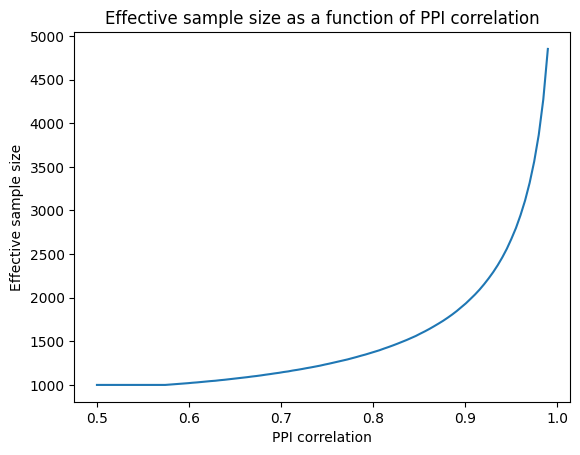

In [18]:
plt.plot(ppi_corrs, effective_ns)
plt.xlabel("PPI correlation")
plt.ylabel("Effective sample size")
plt.title("Effective sample size as a function of PPI correlation")
plt.show()